## Bot Detection
- Data Exploration
- Feature Engineering
- Training and testind

In [107]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from functools import partial
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression


In [3]:
events_pd = pd.read_csv("data/fake_users.csv", index_col=0)

### Data Exploration

##### Columns and types

In [7]:
events_pd.head(5)

,UserId,Event,Category,Fake
0,F7A7BF3761,click_carrousel,Phone,0
1,BA8F7A71E6,send_sms,Motor,0
2,21C64F22FC,send_email,Jobs,0
3,F9E0306603,send_sms,Jobs,0
4,1B2143BACC,click_ad,Phone,0


In [8]:
events_pd.dtypes

UserId      object
Event       object
Category    object
Fake         int64
dtype: object

In [9]:
events_pd.columns

Index(['UserId', 'Event', 'Category', 'Fake'], dtype='object')

#### Completeness and volumetry 

In [12]:
events_pd.count()

UserId      100473
Event       100473
Category    100473
Fake        100473
dtype: int64

In [14]:
# number of users
events_pd.UserId.nunique()

5300

In [17]:
# number of events per user
events_pd.UserId.count() / users_pd.UserId.nunique() 

18.957169811320753

In [144]:
events_pd.Category.value_counts().index

Index(['Motor', 'Holidays', 'Leisure', 'Phone', 'Real_State', 'Jobs'], dtype='object')

In [145]:
list_Categories = ['Motor', 'Holidays', 'Leisure', 'Phone', 'Real_State', 'Jobs']

#### Some countplots

<AxesSubplot:>

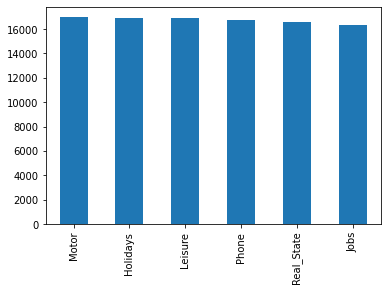

In [25]:
events_pd.Category.value_counts().plot.bar()

In [28]:
events_pd.Event.value_counts()

send_email         22822
click_ad           22201
click_carrousel    18668
phone_call         18430
send_sms           18352
Name: Event, dtype: int64

<AxesSubplot:>

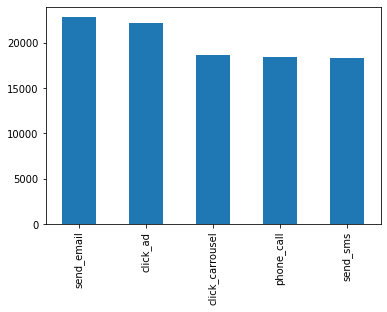

In [26]:
events_pd.Event.value_counts().plot.bar()

<AxesSubplot:xlabel='Event', ylabel='count'>

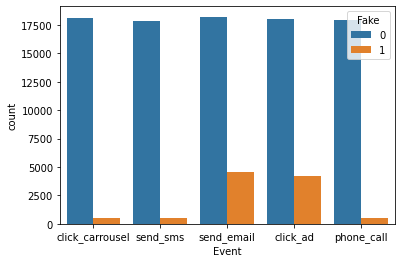

In [31]:
sns.countplot(data=events_pd, x="Event", hue="Fake")

<AxesSubplot:xlabel='Category', ylabel='count'>

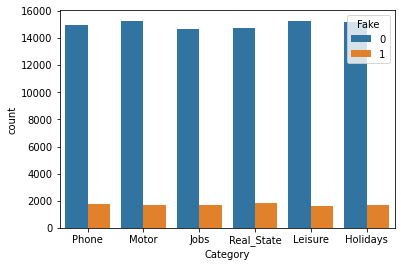

In [32]:
sns.countplot(data=events_pd, x="Category", hue="Fake")

##### Users

##### Numbers of events

<AxesSubplot:xlabel='Event', ylabel='count'>

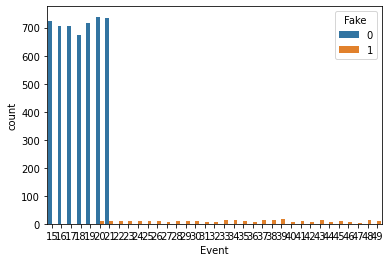

In [101]:
sns.countplot(data=events_pd.groupby(["UserId", "Fake"]).count().reset_index(), x="Event", hue="Fake")

##### Variance of the number of events per Category

<AxesSubplot:xlabel='0', ylabel='count'>

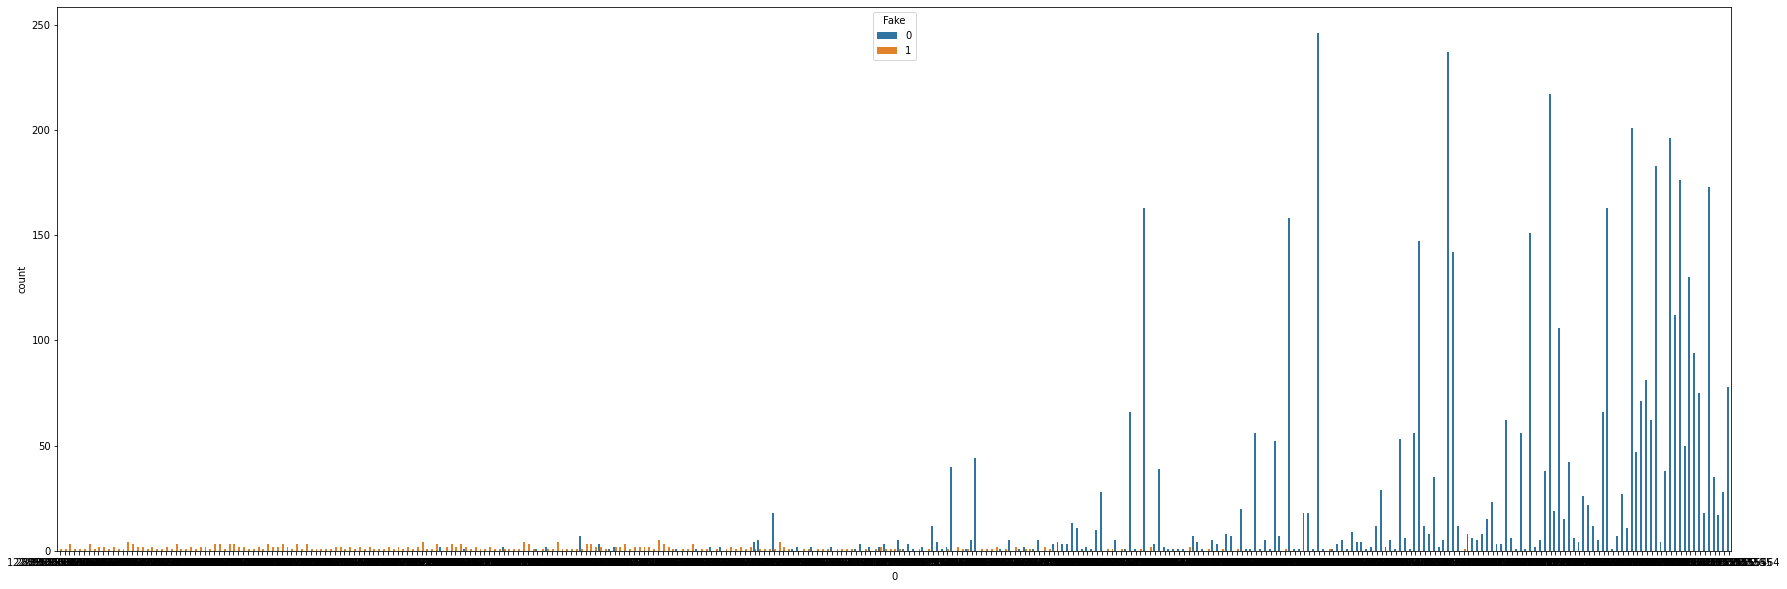

In [155]:
plt.figure(figsize=(30,10))
data = events_pd.groupby(["UserId", "Fake"]).apply(lambda x : np.var([x["Category"].value_counts().to_dict().get(cat, 0) for cat in list_Categories])).reset_index()
sns.countplot(data=data, x=0, hue="Fake")

##### Number of 'send_email' and 'click_ad' events

<AxesSubplot:xlabel='0', ylabel='count'>

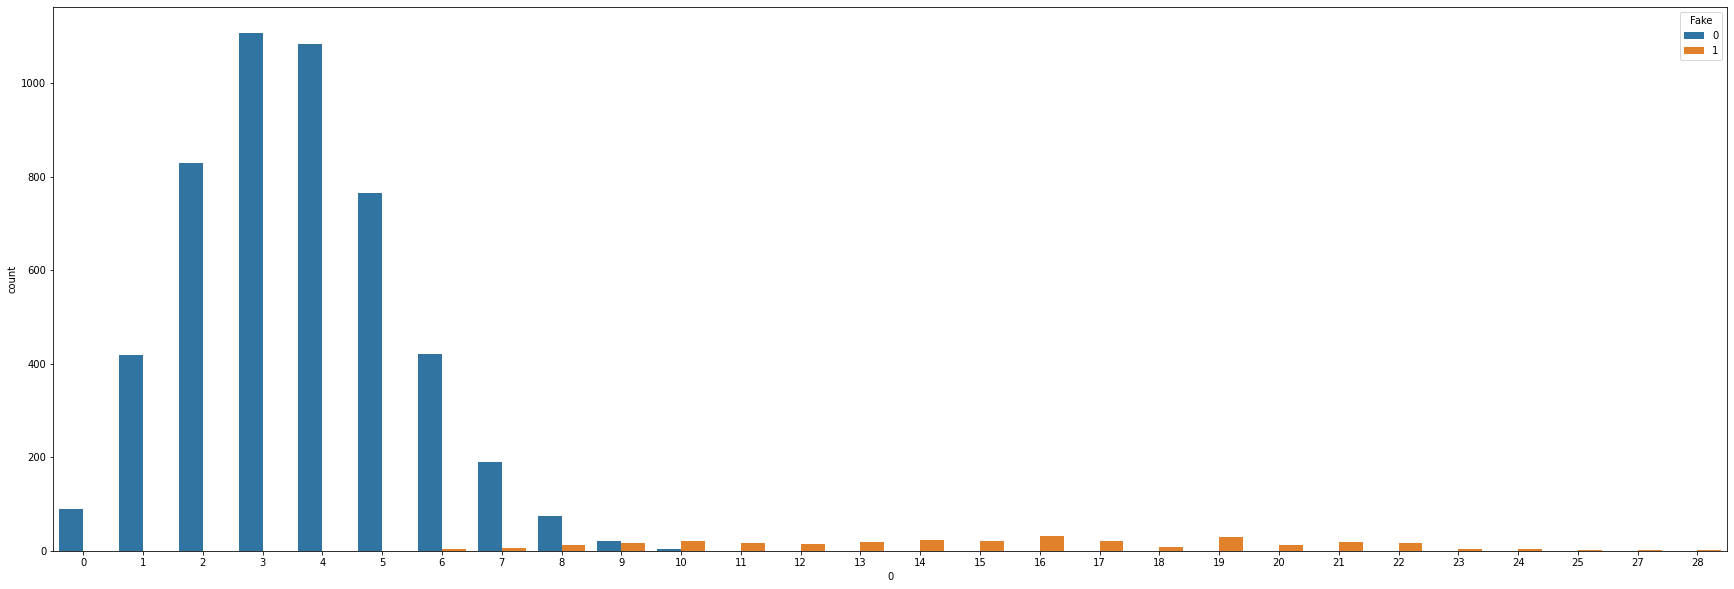

In [114]:
plt.figure(figsize=(30,10))
data = events_pd.groupby(["UserId", "Fake"]).apply(lambda x : sum(x["Event"] == "send_email")).reset_index()
sns.countplot(data=data, x=0, hue="Fake")

<AxesSubplot:xlabel='0', ylabel='count'>

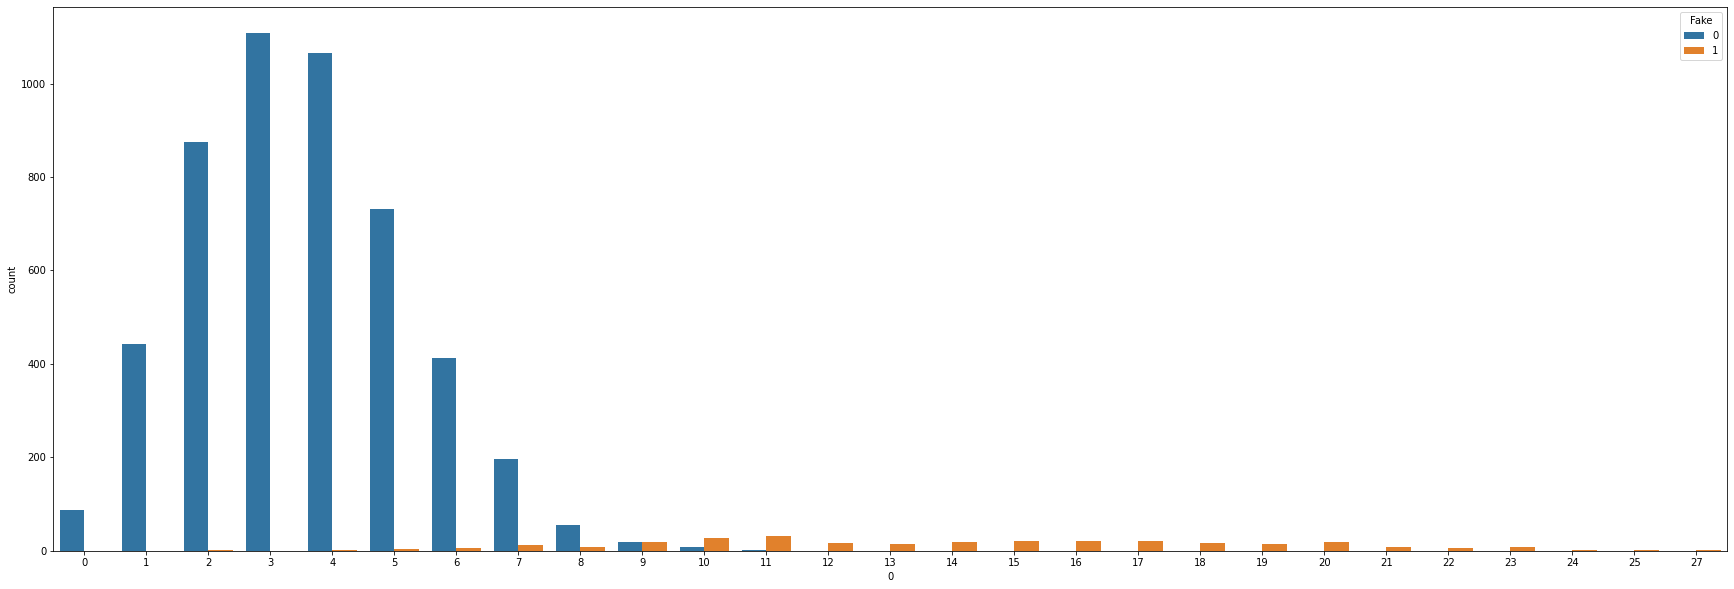

In [118]:
plt.figure(figsize=(30,10))
data = events_pd.groupby(["UserId", "Fake"]).apply(lambda x : sum(x["Event"] == "click_ad")).reset_index()
sns.countplot(data=data, x=0, hue="Fake")

<AxesSubplot:xlabel='0', ylabel='count'>

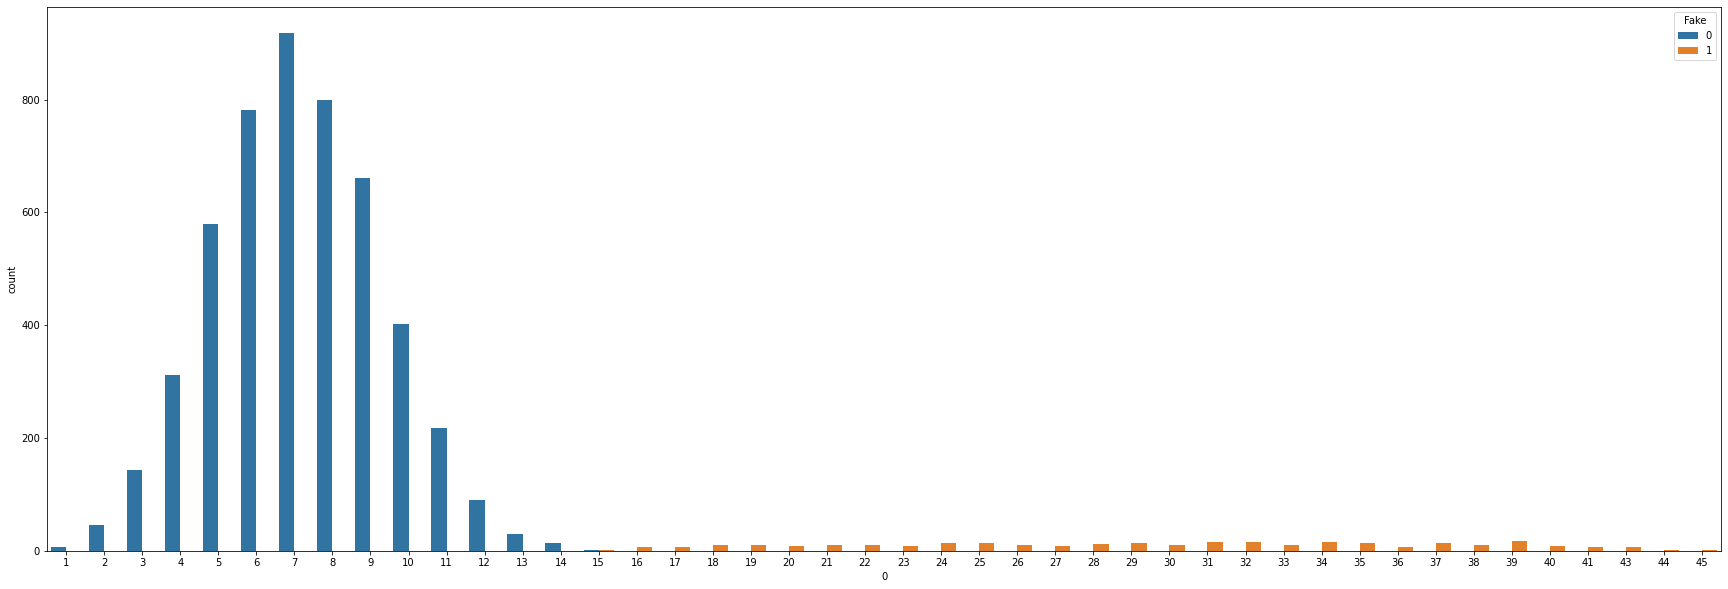

In [119]:
plt.figure(figsize=(30,10))
data = events_pd.groupby(["UserId", "Fake"]).apply(lambda x : sum(x["Event"] == "click_ad") + sum(x["Event"] == "send_email")).reset_index()
sns.countplot(data=data, x=0, hue="Fake")

### Features engineering
- Data aggregation
- Features creation
    - number of events
    - events skewness : number of clicks_ad and send_mail events
    - categories variance

#### Aggregation

In [40]:
def agg_func(df, cat_vars, target_var):
    res_dict = {target_var: df[target_var].max()}
    for var in cat_vars:
        res_dict[var] = df[var].value_counts().to_dict()
    return pd.DataFrame([res_dict.values()], columns=res_dict.keys())

In [76]:
def aggregate_data(df, user_var, cat_vars, target_var):
    agg_df = df.groupby(user_var).apply(partial(agg_func, cat_vars=cat_vars,
                                                        target_var=target_var))
    agg_df = agg_df.reset_index().drop("level_1", axis=1)
    return agg_df

In [77]:
data_agg = aggregate_data(events_pd, user_var="UserId", cat_vars=["Category", "Event"],
                         target_var="Fake")

In [78]:
data_agg

,UserId,Fake,Category,Event
0,00079D439D,0,"{'Phone': 18, 'Holidays': 1}","{'click_ad': 5, 'send_email': 4, 'phone_call':..."
1,0007A4D4AE,0,"{'Phone': 19, 'Leisure': 1}","{'click_carrousel': 7, 'click_ad': 5, 'phone_c..."
2,000AFE2623,0,"{'Holidays': 18, 'Motor': 1, 'Leisure': 1, 'Jo...","{'send_sms': 7, 'click_carrousel': 4, 'send_em..."
3,001A5362BC,0,"{'Leisure': 15, 'Holidays': 1}","{'send_email': 5, 'click_ad': 3, 'click_carrou..."
4,0025995AF5,0,"{'Phone': 14, 'Motor': 3, 'Real_State': 2, 'Ho...","{'click_carrousel': 7, 'click_ad': 4, 'send_sm..."
...,...,...,...,...
5295,FFB0AC6E49,0,"{'Leisure': 16, 'Real_State': 1, 'Jobs': 1}","{'click_ad': 5, 'send_sms': 5, 'send_email': 4..."
5296,FFC56B0CDD,1,"{'Motor': 6, 'Phone': 5, 'Jobs': 5, 'Holidays'...","{'send_email': 10, 'click_ad': 9, 'phone_call'..."
5297,FFD2B9DC06,0,{'Leisure': 20},"{'click_carrousel': 6, 'phone_call': 5, 'send_..."
5298,FFDF962B04,0,"{'Phone': 12, 'Motor': 1, 'Jobs': 1, 'Real_Sta...","{'send_sms': 6, 'click_ad': 4, 'phone_call': 3..."


#### Features engineering pipeline

In [88]:
class DropUnecessaryFeatures(BaseEstimator, TransformerMixin):

    def __init__(self, variables_to_drop=None):
        self.variables_to_drop = variables_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # encode labels
        X = X.copy()
        X = X.drop(self.variables_to_drop, axis=1)

        return X
    
    
class CalculateCategoricalVariance(BaseEstimator, TransformerMixin):

    def __init__(self, variables):
        self.variables = variables

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # encode labels
        X = X.copy()
        for var in self.variables:
            X[var] = X[var].map(lambda x: np.var(list(x.values())))
        return X
    
class CountSubcategories(BaseEstimator, TransformerMixin):

    def __init__(self, col_name, cat_var, subcategories=None):
        self.subcategories = subcategories
        self.col_name = col_name
        self.cat_var = cat_var


    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # encode labels
        X = X.copy()
        if self.subcategories is not None : 
            X[self.col_name] = X[self.cat_var].map(lambda x: np.sum([x.get(cat, 0) for cat in self.subcategories]))
        else:
            X[self.col_name] = X[self.cat_var].map(lambda x: np.sum(list(x.values())))            
        return X

In [98]:
X = data_agg[["Category", "Event"]]
y = data_agg["Fake"]

In [101]:
features_pipeline = Pipeline(
    [
        ('count_events',
            CountSubcategories(col_name="EventCount", cat_var="Event")),
        ('calculate_categories_variance',
            CalculateCategoricalVariance(["Category"])),
        ('calculate_event_skewness',
            CountSubcategories(col_name="EventSkewness", cat_var="Event",
                   subcategories=["click_ad", "send_email"])),
        ('drop_features',
            DropUnecessaryFeatures(variables_to_drop=["Event"]))
    ]
)

In [100]:
features_pipeline.transform(X)

,Category,EventCount,EventSkewness
0,72.2500,19,9
1,81.0000,20,8
2,54.1875,21,7
3,49.0000,16,8
4,24.5600,21,7
...,...,...,...
5295,50.0000,18,9
5296,0.9600,24,19
5297,0.0000,20,8
5298,22.6875,15,5


## Training and testing

In [102]:
model_pipe = Pipeline(
    [
        ('count_events',
            CountSubcategories(col_name="EventCount", cat_var="Event")),
        ('calculate_categories_variance',
            CalculateCategoricalVariance(["Category"])),
        ('calculate_event_skewness',
            CountSubcategories(col_name="EventSkewness", cat_var="Event",
                   subcategories=["click_ad", "send_email"])),
        ('drop_features',
            DropUnecessaryFeatures(variables_to_drop=["Event"])),
        ('lr_model',
            LogisticRegression(random_state=0))
    ]
)

In [103]:
model_pipe.fit(X, y)

Pipeline(steps=[('count_events',
                 CountSubcategories(cat_var='Event', col_name='EventCount')),
                ('calculate_categories_variance',
                 CalculateCategoricalVariance(variables=['Category'])),
                ('calculate_event_skewness',
                 CountSubcategories(cat_var='Event', col_name='EventSkewness',
                                    subcategories=['click_ad', 'send_email'])),
                ('drop_features',
                 DropUnecessaryFeatures(variables_to_drop=['Event'])),
                ('lr_model', LogisticRegression(random_state=0))])

In [104]:
y_pred = model_pipe.predict(X)
score_ = model_pipe.score(X, y)
conf_m = confusion_matrix(y, y_pred)
report = classification_report(y, y_pred)

In [108]:
score_

1.0

In [105]:
conf_m

array([[5000,    0],
       [   0,  300]])

In [106]:
print('report:', report, sep='\n')

report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5000
           1       1.00      1.00      1.00       300

    accuracy                           1.00      5300
   macro avg       1.00      1.00      1.00      5300
weighted avg       1.00      1.00      1.00      5300



### Test data

In [109]:
events_pd_test = pd.read_csv("data/fake_users_test.csv", index_col=0)

In [110]:
data_test = aggregate_data(events_pd_test, user_var="UserId", cat_vars=["Category", "Event"],
                         target_var="Fake")

In [111]:
X_test = data_test[["Category", "Event"]]
y_test = data_test["Fake"]

In [112]:
y_test_pred = model_pipe.predict(X_test)
score_ = model_pipe.score(X_test, y_test)
conf_m = confusion_matrix(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred)

In [113]:
conf_m

array([[142,   0],
       [  0,  10]])

In [114]:
print('report:', report, sep='\n')

report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       142
           1       1.00      1.00      1.00        10

    accuracy                           1.00       152
   macro avg       1.00      1.00      1.00       152
weighted avg       1.00      1.00      1.00       152



##### Without need to try diffrent ML models and tune parameters, we reach an accuracy of 1 on test data.
### We select this model